In [30]:
import pandas as pd

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import features as fea
import data_source as ds
from random import randint
reload(ds)
reload(fea)

import sklearn.metrics as metrics
from sklearn import cross_validation
from sklearn import ensemble, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [2]:
dt_df = ds.get_date_df()
obj_df = ds.get_obj_df()

train_enroll = ds.get_enrollment_df('train')
train_log = ds.get_log_df('train')
train_labels = ds.get_labels_df()

test_enroll = ds.get_enrollment_df('test')
test_log = ds.get_log_df('test')


In [3]:
train_enroll.shape

(120542, 3)

In [4]:
"""
Base Feature
"""
train_base = pd.DataFrame()
train_base['enrollment_id'] = train_enroll['enrollment_id']
train_base['username'] = train_enroll['username']

train_base = pd.merge(train_base, fea.activity_total_and_percentile(enroll_df=train_enroll, log_df=train_log, dt_df=dt_df).sort('enrollment_id'), on=['enrollment_id'], how='left')
print train_base.shape
"""
Course Level Feature
"""
new_train_base = pd.merge(train_base, fea.avg_activity_per_course_event(enroll_df=train_enroll, log_df=train_log), on=['course_id'], how='left')
print new_train_base.shape
"""
Day Range Level Feature
"""
whole_new_train_base = pd.merge(new_train_base, fea.activity_filtered(enroll_df=train_enroll, log_df=train_log, dt_df=dt_df), on=['enrollment_id'], how='left')
print whole_new_train_base.shape
"""
Enrollment Level - Action Dow
"""
# whole_new_train_base = pd.merge(whole_new_train_base, fea.action_dow(enroll_df=train_enroll, log_df=train_log, dt_df=dt_df), on=['enrollment_id'], how='left')
# print whole_new_train_base.shape
# whole_new_train_base.head()

"""
Dummy Course_id Features
"""
whole_new_train_base = whole_new_train_base.join(fea.dummy_course_id(enroll_df=train_enroll, log_df=train_log, dt_df=dt_df))
print whole_new_train_base.shape

# """
# Add User Drop Rate
# """
# whole_new_train_base = pd.merge(whole_new_train_base, fea.user_drop_rate(enroll_df=train_enroll, df_truth=train_labels), on=['username'], how='left')
# print whole_new_train_base.shape

"""
Add Course Drop Rate
"""
whole_new_train_base = pd.merge(whole_new_train_base, fea.course_drop_rate(enroll_df=train_enroll, df_truth=train_labels), on=['course_id'], how='left')
print whole_new_train_base.shape


(120542, 19)
(120542, 27)
(120542, 36)
(120542, 75)
(120542, 76)


In [23]:
user_cluster_df = fea.k_mean_user_df(enroll_df=train_enroll, log_df=train_log, dt_df=dt_df)
kmean_model, user_label_df = fea.train_kmean(user_cluster_df)
whole_new_train_base = pd.merge(whole_new_train_base, user_label_df,  on=['enrollment_id'], how='left')
print whole_new_train_base.shape

In [27]:
final_train_base = whole_new_train_base

# Adjust Avg
event_list = train_log.event.unique().tolist()
final_train_base['diff_activity'] = final_train_base['total_activity'] - final_train_base['avg_activity']
for e in event_list:
    final_train_base['diff_%s_activity' % e] = final_train_base['total_%s_activity' % e] - final_train_base['avg_activity_%s' % e]

log_target = [
 'total_activity',
 'total_navigate_activity',
 'total_access_activity',
 'total_problem_activity',
 'total_page_close_activity',
 'total_video_activity',
 'total_discussion_activity', 
 'total_wiki_activity',
 'total_activity_top_5',
 'total_activity_tail_5',
 'total_activity_top_10',
 'total_activity_tail_10',
 'total_activity_top_15',
 'total_activity_tail_15']
log_features = np.log(final_train_base[log_target]+1)
features = filter(lambda x: x not in log_target, whole_new_train_base.columns.tolist())
final_train_base = final_train_base[features]
final_train_base = final_train_base.join(log_features)

# Filter
blacklist = ['course_id', 'enrollment_id', 'username',
 'avg_activity',
 'avg_activity_navigate',
 'avg_activity_access',
 'avg_activity_problem',
 'avg_activity_page_close',
 'avg_activity_video',
 'avg_activity_discussion',
 'avg_activity_wiki'] 
features = filter(lambda x: x not in blacklist, whole_new_train_base.columns.tolist())
final_train_base = final_train_base[features]

labels = train_labels[1]

In [40]:
#final_train_base['user_drop_rate']
final_train_base.shape

(120542, 74)

In [54]:
"""
s2-with-percentile
Accuracy: 0.87030 (+/- 0.00)
ROC: 0.86251 (+/- 0.00)
Accuracy: 0.87231 (+/- 0.00)
ROC: 0.86287 (+/- 0.00)
"""
import sklearn.metrics as metrics
from sklearn import cross_validation
from sklearn import ensemble, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
# Random Forest Classifier
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=1, max_depth=3)
cv = cross_validation.ShuffleSplit(final_train_base.shape[0], n_iter=3,
        test_size=0.3, random_state=0)
scores = cross_validation.cross_val_score(
            clf, final_train_base, labels, cv=cv)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=1, max_depth=3)
cv = cross_validation.ShuffleSplit(final_train_base.shape[0], n_iter=3,
        test_size=0.3, random_state=0)
scores = cross_validation.cross_val_score(
            clf, final_train_base, labels, cv=cv, scoring='roc_auc')
print("ROC: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87009 (+/- 0.00)
ROC: 0.86662 (+/- 0.00)


In [129]:
# Train The Classifier
# clf.fit(final_train_base, labels)

In [33]:
# Load Test
# test_enroll = ds.get_enrollment_df('test')
# test_log = ds.get_log_df('test')
"""
Base Feature
"""
test_base = pd.DataFrame()
test_base['enrollment_id'] = test_enroll['enrollment_id']
test_base['username'] = test_enroll['username']

test_base = pd.merge(test_base, fea.activity_total_and_percentile(enroll_df=test_enroll, log_df=test_log, dt_df=dt_df).sort('enrollment_id'), on=['enrollment_id'], how='left')
print test_base.shape
"""
Course Level Feature
"""
new_test_base = pd.merge(test_base, fea.avg_activity_per_course_event(enroll_df=test_enroll, log_df=test_log), on=['course_id'], how='left')
print new_test_base.shape
"""
Day Range Level Feature
"""
whole_new_test_base = pd.merge(new_test_base, fea.activity_filtered(enroll_df=test_enroll, log_df=test_log, dt_df=dt_df), on=['enrollment_id'], how='left')
print whole_new_test_base.shape
"""
Enrollment Level - Action Dow
"""
# whole_new_test_base = pd.merge(whole_new_test_base, fea.action_dow(enroll_df=test_enroll, log_df=test_log, dt_df=dt_df), on=['enrollment_id'], how='left')
# print whole_new_test_base.shape
# whole_new_test_base.head()

"""
Dummy Course_id Features
"""
whole_new_test_base = whole_new_test_base.join(fea.dummy_course_id(enroll_df=test_enroll, log_df=test_log, dt_df=dt_df))
print whole_new_test_base.shape

# """
# Add User Drop Rate (from Train)
# """
# whole_new_test_base = pd.merge(whole_new_test_base, fea.user_drop_rate(enroll_df=train_enroll, df_truth=train_labels), on=['username'], how='left')
# user_drop_mean = whole_new_test_base.user_drop_rate.mean()
# whole_new_test_base['user_drop_rate'] = whole_new_test_base.user_drop_rate.fillna(user_drop_mean)
# print whole_new_test_base.shape

"""
Add Course Drop Rate (from Train)
"""
whole_new_test_base = pd.merge(whole_new_test_base, fea.course_drop_rate(enroll_df=train_enroll, df_truth=train_labels), on=['course_id'], how='left')
print whole_new_test_base.shape


(80362, 19)
(80362, 27)
(80362, 36)
(80362, 75)
(80362, 76)


In [47]:
"""
Add KMean Features
"""
user_cluster_df = fea.k_mean_user_df(enroll_df=test_enroll, log_df=test_log, dt_df=dt_df)
whole_new_test_base['kmean_labels'] = kmean_model.predict(user_cluster_df.values)

In [36]:
#whole_new_test_base

In [48]:
final_test_base = whole_new_test_base

# Adjust Avg
event_list = test_log.event.unique().tolist()
final_test_base['diff_activity'] = final_test_base['total_activity'] - final_test_base['avg_activity']
for e in event_list:
    final_test_base['diff_%s_activity' % e] = final_test_base['total_%s_activity' % e] - final_test_base['avg_activity_%s' % e]

log_target = [
 'total_activity',
 'total_navigate_activity',
 'total_access_activity',
 'total_problem_activity',
 'total_page_close_activity',
 'total_video_activity',
 'total_discussion_activity', 
 'total_wiki_activity',
 'total_activity_top_5',
 'total_activity_tail_5',
 'total_activity_top_10',
 'total_activity_tail_10',
 'total_activity_top_15',
 'total_activity_tail_15']
log_features = np.log(final_test_base[log_target]+1)
features = filter(lambda x: x not in log_target, whole_new_test_base.columns.tolist())
final_test_base = final_test_base[features]
final_test_base = final_test_base.join(log_features)

# Filter
blacklist = ['course_id', 'enrollment_id', 'username',
 'avg_activity',
 'avg_activity_navigate',
 'avg_activity_access',
 'avg_activity_problem',
 'avg_activity_page_close',
 'avg_activity_video',
 'avg_activity_discussion',
 'avg_activity_wiki'] 
features = filter(lambda x: x not in blacklist, whole_new_test_base.columns.tolist())
final_test_base = final_test_base[features]

In [49]:
set(final_test_base.columns.tolist()) ^ set(final_train_base.columns.tolist())

set()

In [50]:
# Prediction I
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=1, random_state=0)
clf.fit(final_train_base, labels)
test_prediction=clf.predict_proba(final_test_base)[:,1]

# Prediction II
# prediction_list = pd.DataFrame()
# for i in range(15):
#     print "iter:%s" % i
#     r_int = randint(1, 100)
#     clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=300, min_samples_split=1, random_state=r_int)
#     clf.fit(final_train_base, labels)
#     prediction_list['r%s' % i] = clf.predict_proba(final_test_base)[:,1]
# print prediction_list.head()
# test_prediction = prediction_list.mean(axis=1)

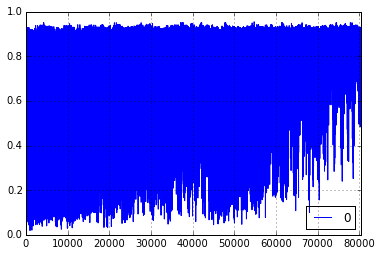

In [13]:
pd.DataFrame(test_prediction).plot()

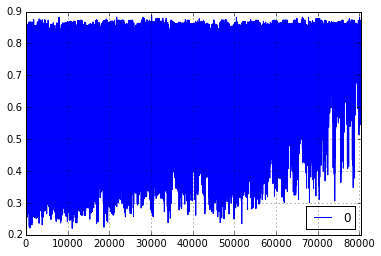

In [52]:
pd.DataFrame(test_prediction).plot()

In [14]:
#Output Submission
sample_sub_df = ds.get_sample_submission()
sample_sub_df[1] = test_prediction
sample_sub_df.to_csv('submission/s6-with-drop-rate.csv', index=False, header=False)

In [ ]:
# Smoke Test With ROC Curve
predicted_labels = clf.predict_proba(final_train_base)[:,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr = dict()
tpr = dict()
roc_score = roc_auc_score(labels, predicted_labels)
fpr['model'], tpr['model'], _ = roc_curve(labels, predicted_labels)

plt.figure()
plt.plot(fpr['model'], tpr['model'], label='ROC curve (area = %0.5f)' % roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.1])
plt.ylim([0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()